In [1]:
import pandas as pd
import geopandas as gpd
import os
from tqdm import tqdm

from config import config

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# replace the ori_str to corresponding mode in mode_dict
def _encode(ori_str, mode_dict):
    for mode, value in mode_dict.items():
        ori_str = ori_str.replace(mode, value)
    ori_str = ori_str.replace("\n", "")
    return ori_str

trips_df = pd.read_csv(os.path.join(config["S_proc"], "trips_forMainMode.csv"))


mode_dict = {
    "Mode::Airplane": "",
    "Mode::Bicycle": "Bike",
    "Mode::Boat": "Bus",
    "Mode::Bus": "Bus",
    "Mode::Car": "Car",
    "Mode::Coach": "Coach",
    "Mode::Ebicycle": "EBike",
    "Mode::Ecar": "ECar",
    "Mode::Ski": "",
    "Mode::Train": "Train",
    "Mode::Tram": "Tram",
    "Mode::Walk": "Walk",
}
trips_df["mode_len"] = [_encode(i, mode_dict) for i in trips_df["mode_len"].to_list()]

In [3]:
from joblib import Parallel, delayed
import multiprocessing

def applyParallel(dfGrouped, func):
    # multiprocessing.cpu_count()
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for _, group in tqdm(dfGrouped))
    return pd.concat(retLst)

def get_unique_mode_distance(df):
    df = df.iloc[0]
    modes = " ".join(df["mode_len"][1:-1].split()).split(" ")
    dist = " ".join(df["mode_lenProp"][1:-1].split()).split(" ")
    mode_df = pd.DataFrame([modes, dist]).T
    mode_df.columns=["Mode","Distance"]
    mode_df["Distance"] = mode_df["Distance"].astype("float")
    
    top2 = mode_df.groupby("Mode", as_index=False).sum().sort_values(by="Distance", ascending=False).head(2)
    res_dict = {}
    res_dict["id"] = df["id"]
    res_dict["mode_1"] = top2["Mode"].values[0]
    res_dict["modeProp_1"] = top2["Distance"].values[0]
    if len(top2) == 2:
        res_dict["mode_2"] = top2["Mode"].values[1]
        res_dict["modeProp_2"] = top2["Distance"].values[1]

    return pd.Series(res_dict).to_frame().T

# tqdm.pandas(desc="Extract mode")
# extracted_df = trips_df.progress_apply(get_unique_mode_distance, axis=1)
extracted_df = applyParallel(trips_df.groupby("id"), get_unique_mode_distance)
extracted_df.index = np.arange(len(extracted_df))
extracted_df = extracted_df.loc[(extracted_df["mode_1"] != "''") & (extracted_df["mode_2"] != "''")]

100%|████████████████████████████████████████████████████████████████████████| 245689/245689 [03:39<00:00, 1120.07it/s]


In [4]:
extracted_df["mode_1"].unique()

array(["'Train'", "'Walk'", "'Car'", "'ECar'", "'Bike'", "'Bus'",
       "'Tram'", "'Coach'", "'EBike'"], dtype=object)

In [5]:
extracted_df

,id,mode_1,modeProp_1,mode_2,modeProp_2
0,0,'Train',0.936252,'Walk',0.0637482
1,1,'Train',0.944693,'Walk',0.0553069
2,2,'Walk',1,NaN,NaN
3,3,'Walk',1,NaN,NaN
4,4,'Car',1,NaN,NaN
...,...,...,...,...,...
245684,245684,'Car',0.794674,'Walk',0.205326
245685,245685,'Walk',0.573189,'Train',0.339477
245686,245686,'Car',1,NaN,NaN
245687,245687,'Car',1,NaN,NaN


In [6]:
# percentage of trips with only one main mode
print(sum(~extracted_df['mode_2'].isna())/extracted_df.shape[0] *100)

29.10482403348848


In [7]:
multiMode_df = extracted_df.loc[~extracted_df['mode_2'].isna()].copy()

multiMode_df["mode_1"] = multiMode_df["mode_1"].apply(lambda x: x[1:-1])
multiMode_df["mode_2"] = multiMode_df["mode_2"].apply(lambda x: x[1:-1])
multiMode_df

,id,mode_1,modeProp_1,mode_2,modeProp_2
0,0,Train,0.936252,Walk,0.0637482
1,1,Train,0.944693,Walk,0.0553069
12,12,Car,0.914747,Walk,0.0852535
13,13,Car,0.995096,Walk,0.00490357
17,17,Car,0.985686,Walk,0.0143141
...,...,...,...,...,...
245676,245676,Walk,0.972078,Car,0.027922
245677,245677,Train,0.996867,Walk,0.00313281
245683,245683,Car,0.555371,Walk,0.280403
245684,245684,Car,0.794674,Walk,0.205326


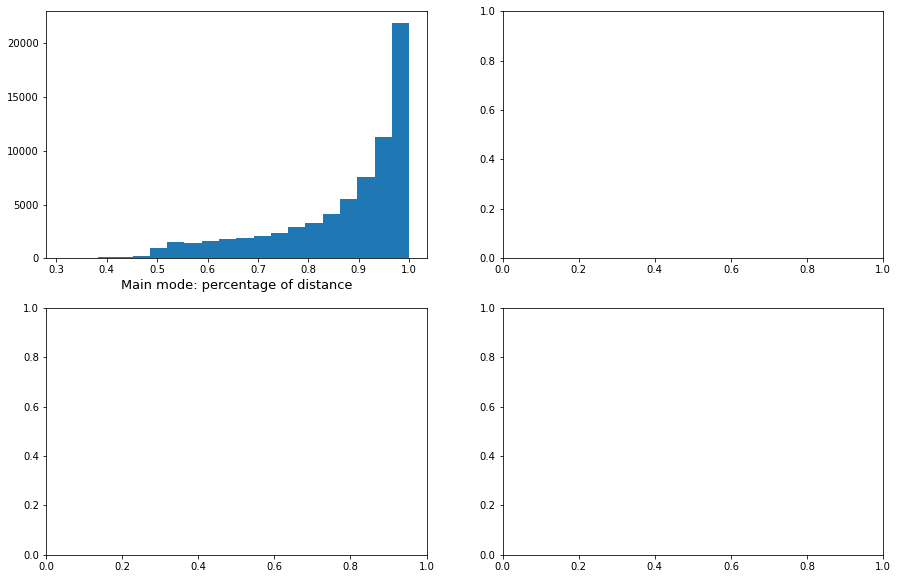

In [8]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))
axs[0, 0].hist(multiMode_df['modeProp_1'],bins=20)
axs[0, 0].set_xlabel("Main mode: percentage of distance", fontsize=13)

# axs[0, 1].hist(multiMode_df['mode_dp1'],bins=20)
# axs[0, 1].set_xlabel("Main mode: percentage of distance", fontsize=13)

# axs[1, 0].hist(multiMode_df['mode_tp1'] - multiMode_df['mode_tp2'],bins=20)
# axs[1, 0].set_xlabel("Diff: percentage of time", fontsize=13)

# axs[1, 1].hist(multiMode_df['mode_dp1'] - multiMode_df['mode_dp2'],bins=20)
# axs[1, 1].set_xlabel("Diff: percentage of distance", fontsize=13)


plt.show()

* Distance is a better indicator than time: the difference of first and second rank mode is much higher

In [8]:
no_walk = multiMode_df.loc[(multiMode_df["mode_1"] != "Walk") & (multiMode_df["mode_2"] != "Walk")]
freq = no_walk.groupby(['mode_1', 'mode_2']).size().unstack().fillna(0)
freq

mode_2,Bike,Bus,Car,Coach,EBike,ECar,Train,Tram
mode_1,,,,,,,,
Bike,0.0,67.0,231.0,0.0,1.0,62.0,66.0,20.0
Bus,49.0,0.0,114.0,1.0,0.0,42.0,141.0,154.0
Car,520.0,313.0,0.0,0.0,2.0,18.0,695.0,110.0
Coach,3.0,3.0,11.0,0.0,0.0,8.0,7.0,0.0
EBike,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
ECar,168.0,189.0,11.0,4.0,2.0,0.0,668.0,75.0
Train,1990.0,2753.0,3833.0,12.0,47.0,7871.0,0.0,1310.0
Tram,33.0,48.0,34.0,2.0,0.0,15.0,24.0,0.0


In [9]:
per = freq / freq.sum(axis=1)[:,np.newaxis]

per = per*100
per

C:\Users\hong\anaconda3\envs\conserved\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


mode_2,Bike,Bus,Car,Coach,EBike,ECar,Train,Tram
mode_1,,,,,,,,
Bike,0.000000,14.988814,51.677852,0.000000,0.223714,13.870246,14.765101,4.474273
Bus,9.780439,0.000000,22.754491,0.199601,0.000000,8.383234,28.143713,30.738523
Car,31.363088,18.878166,0.000000,0.000000,0.120627,1.085645,41.917973,6.634499
Coach,9.375000,9.375000,34.375000,0.000000,0.000000,25.000000,21.875000,0.000000
EBike,40.000000,20.000000,20.000000,0.000000,0.000000,0.000000,20.000000,0.000000
ECar,15.040286,16.920322,0.984781,0.358102,0.179051,0.000000,59.803044,6.714414
Train,11.169735,15.452402,21.514369,0.067355,0.263808,44.179389,0.000000,7.352941
Tram,21.153846,30.769231,21.794872,1.282051,0.000000,9.615385,15.384615,0.000000


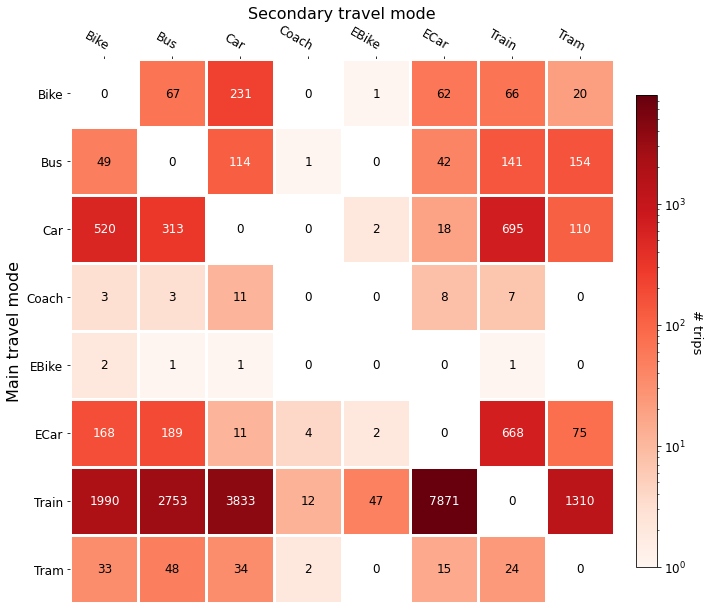

In [31]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", fontsize = 12, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    
    # Create an axes for colorbar. The position of the axes is calculated based on the position of ax.
    # You can change 0.01 to adjust the distance between the main image and the colorbar.
    # You can change 0.02 to adjust the width of the colorbar.
    # This practice is universal for both subplots and GeoAxes.
    cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0 +0.05,0.03,ax.get_position().height - 0.1])
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=13)
    cbar.ax.tick_params(labelsize=12) 

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=fontsize)
    ax.set_yticklabels(row_labels, fontsize=fontsize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.
    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):

            if data[i, j] == 0:
                kw.update(color=textcolors[0])
            else:
                kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(10,10))

im, cbar = heatmap(freq, freq.index, freq.columns, ax=ax, cmap="Reds", fontsize=12, cbarlabel="# trips", norm=LogNorm())
texts = annotate_heatmap(im, valfmt="{x:.0f}", fontsize=12)

ax.set_ylabel('Main travel mode', fontsize=16)
ax.set_xlabel('Secondary travel mode', fontsize=16)
ax.xaxis.set_label_position('top') 
# fig.tight_layout()
plt.savefig(r'C:\Work\Projects\GIScience\data\Figure\modality.png', bbox_inches='tight', dpi=600)
plt.show()

In [119]:
res = []
for i in range(per.shape[0]-1):
    print('{}: {:.2}'.format(freq.columns[i], per.iloc[i,i]+ per.iloc[i,-1]) )


Airplane: 0.24
Bicycle: 0.83
Boat: 0.79
Bus: 0.86
Car: 0.92
Coach: 0.77
Ebicycle: 0.94
Ecar: 0.94
Ski: 0.92
Train: 0.61
Tram: 0.92


## Train trips: how are the mode mixed?

In [136]:
train_df = multiMode_df.loc[multiMode_df['mode_d1'] == 'Train']
train_df = train_df.loc[(train_df['mode_d2'] != 'Train') & (train_df['mode_d2'] != 'Walk')]
mode_1 = train_df['mode_dp1'].values
mode_2 = train_df['mode_dp2'].values

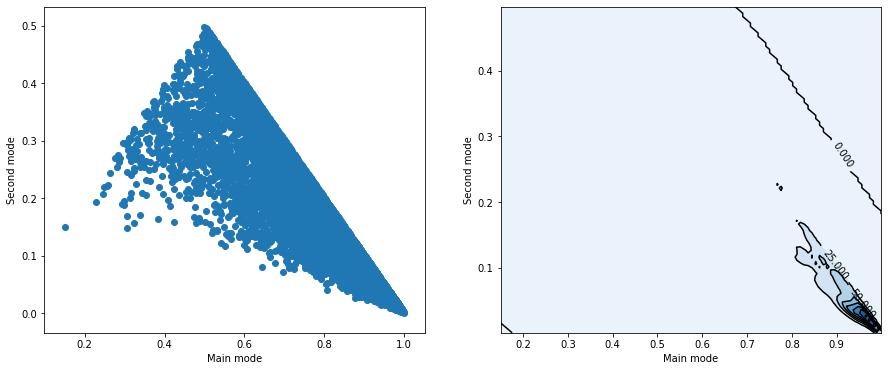

In [151]:
import scipy.stats as st

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.scatter(mode_1, mode_2)
ax1.set_xlabel("Main mode")
ax1.set_ylabel("Second mode")

# Peform the kernel density estimate
xx, yy = np.mgrid[mode_1.min():mode_1.max():100j, mode_2.min():mode_2.max():100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([mode_1, mode_2])
kernel = st.gaussian_kde(values)
kernel.set_bandwidth(bw_method=kernel.factor / 3.)
f = np.reshape(kernel(positions).T, xx.shape)

ax2.set_xlim(mode_1.min(), mode_1.max())
ax2.set_ylim(mode_2.min(), mode_2.max())
cfset = ax2.contourf(xx, yy, f, cmap='Blues')

cset =ax2.contour(xx, yy, f, colors='k')
ax2.clabel(cset, inline=1, fontsize=10)
ax2.set_xlabel('Main mode')
ax2.set_ylabel('Second mode')

plt.show()